## Import modules and data

In [1]:
import pandas as pd
import os
import matplotlib.pyplot as plt
import numpy as np
from scipy.optimize import curve_fit
from titeseq_functions import *
from multiprocessing import Pool
from functools import partial
from collections import Counter

/sw/pkgs/arc/python3.9-anaconda/2021.11/lib/python3.9/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.1
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
#get raw data (with only relevant columns)
fit_data_save_location = '/scratch/gthurber_root/gthurber0/marcase/titeseq/fit_data/'
binary_data = pd.read_csv(fit_data_save_location+'merged_binary_bloom2022.csv')
binary_data

,Unnamed: 0,target,variant_call_support,codon_substitutions,aa_substitutions,n_codon_substitutions,n_aa_substitutions,"('TiteSeq_04_bin4', 'A')","('TiteSeq_04_bin1', 'A')","('TiteSeq_04_bin4', 'B')","('TiteSeq_04_bin1', 'B')"
0,TTAAATCTACTAAAAG_lib1,Delta,80.0,CAG176CCA,Q176P,1.0,1.0,0.0,4927.0,NaN,NaN
1,AAAAGCTCCCACCCGA_lib1,Delta,31.0,GGT9GAT CAG176CCA,G9D Q176P,2.0,2.0,0.0,2834.0,NaN,NaN
2,AATGACATGGAGCTTA_lib1,Delta,92.0,TTC70GAT AAC171AGA,F70D N171R,2.0,2.0,0.0,3116.0,NaN,NaN
3,TCACAATATCGCGTGT_lib1,Delta,59.0,GGC86TTT CTG95CTT GCA192TTG,G86F A192L,3.0,2.0,5.0,2320.0,NaN,NaN
4,ATCCAAACAAATTGCA_lib1,Delta,65.0,GGA172TCT,G172S,1.0,1.0,0.0,3196.0,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...
543660,TTTTTACAATATACAC_pool2,NaN,NaN,NaN,NaN,NaN,NaN,0.0,205.0,NaN,NaN
543661,TTTTTACACAGTAAGT_pool2,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,NaN,NaN
543662,TTTTTACCTGTTTGTT_pool2,NaN,NaN,NaN,NaN,NaN,NaN,5.0,0.0,NaN,NaN
543663,TTTTTAGAAAGGTACA_pool2,NaN,NaN,NaN,NaN,NaN,NaN,70.0,0.0,NaN,NaN


### get sequences of defined variants and create dictionary

In [3]:
#sequences of variants - all padded with ' ' at beginning to align mutations with sequence
B1351_seq      =  ' NITNLCPFGEVFNATRFASVYAWNRKRISNCVADYSVLYNSASFSTFKCYGVSPTKLNDLCFTNVYADSFVIRGDEVRQIAPGQTGNIADYNYKLPDDFTGCVIAWNSNNLDSKVGGNYNYLYRLFRKSNLKPFERDISTEIYQAGSTPCNGVKGFNCYFPLQSYGFQPTYGVGYQPYRVVVLSFELLHAPATVCGPKKST'
E484K_seq      =  ' NITNLCPFGEVFNATRFASVYAWNRKRISNCVADYSVLYNSASFSTFKCYGVSPTKLNDLCFTNVYADSFVIRGDEVRQIAPGQTGKIADYNYKLPDDFTGCVIAWNSNNLDSKVGGNYNYLYRLFRKSNLKPFERDISTEIYQAGSTPCNGVKGFNCYFPLQSYGFQPTNGVGYQPYRVVVLSFELLHAPATVCGPKKST'
N5O1Y_seq      =  ' NITNLCPFGEVFNATRFASVYAWNRKRISNCVADYSVLYNSASFSTFKCYGVSPTKLNDLCFTNVYADSFVIRGDEVRQIAPGQTGKIADYNYKLPDDFTGCVIAWNSNNLDSKVGGNYNYLYRLFRKSNLKPFERDISTEIYQAGSTPCNGVEGFNCYFPLQSYGFQPTYGVGYQPYRVVVLSFELLHAPATVCGPKKST'
Wuhan_Hu_1_seq =  ' NITNLCPFGEVFNATRFASVYAWNRKRISNCVADYSVLYNSASFSTFKCYGVSPTKLNDLCFTNVYADSFVIRGDEVRQIAPGQTGKIADYNYKLPDDFTGCVIAWNSNNLDSKVGGNYNYLYRLFRKSNLKPFERDISTEIYQAGSTPCNGVEGFNCYFPLQSYGFQPTNGVGYQPYRVVVLSFELLHAPATVCGPKKST'
WT_seq         =  ' NITNLCPFGEVFNATRFASVYAWNRKRISNCVADYSVLYNSASFSTFKCYGVSPTKLNDLCFTNVYADSFVIRGDEVRQIAPGQTGKIADYNYKLPDDFTGCVIAWNSNNLDSKVGGNYNYLYRLFRKSNLKPFERDISTEIYQAGSTPCNGVEGFNCYFPLQSYGFQPTNGVGYQPYRVVVLSFELLHAPATVCGPKKST'
delta_seq      =  ' NITNLCPFGEVFNATRFASVYAWNRKRISNCVADYSVLYNSASFSTFKCYGVSPTKLNDLCFTNVYADSFVIRGDEVRQIAPGQTGKIADYNYKLPDDFTGCVIAWNSNNLDSKVGGNYNYRYRLFRKSNLKPFERDISTEIYQAGSKPCNGVEGFNCYFPLQSYGFQPTNGVGYQPYRVVVLSFELLHAPATVCGPKKST'

ids = ['B1351','E484K','Wuhan_Hu_1','N501Y','Delta']
sequences = [B1351_seq,E484K_seq,Wuhan_Hu_1_seq,N5O1Y_seq,delta_seq]
seq_dict = dict(zip(ids,sequences))
seq_dict

{'B1351': ' NITNLCPFGEVFNATRFASVYAWNRKRISNCVADYSVLYNSASFSTFKCYGVSPTKLNDLCFTNVYADSFVIRGDEVRQIAPGQTGNIADYNYKLPDDFTGCVIAWNSNNLDSKVGGNYNYLYRLFRKSNLKPFERDISTEIYQAGSTPCNGVKGFNCYFPLQSYGFQPTYGVGYQPYRVVVLSFELLHAPATVCGPKKST',
 'E484K': ' NITNLCPFGEVFNATRFASVYAWNRKRISNCVADYSVLYNSASFSTFKCYGVSPTKLNDLCFTNVYADSFVIRGDEVRQIAPGQTGKIADYNYKLPDDFTGCVIAWNSNNLDSKVGGNYNYLYRLFRKSNLKPFERDISTEIYQAGSTPCNGVKGFNCYFPLQSYGFQPTNGVGYQPYRVVVLSFELLHAPATVCGPKKST',
 'Wuhan_Hu_1': ' NITNLCPFGEVFNATRFASVYAWNRKRISNCVADYSVLYNSASFSTFKCYGVSPTKLNDLCFTNVYADSFVIRGDEVRQIAPGQTGKIADYNYKLPDDFTGCVIAWNSNNLDSKVGGNYNYLYRLFRKSNLKPFERDISTEIYQAGSTPCNGVEGFNCYFPLQSYGFQPTNGVGYQPYRVVVLSFELLHAPATVCGPKKST',
 'N501Y': ' NITNLCPFGEVFNATRFASVYAWNRKRISNCVADYSVLYNSASFSTFKCYGVSPTKLNDLCFTNVYADSFVIRGDEVRQIAPGQTGKIADYNYKLPDDFTGCVIAWNSNNLDSKVGGNYNYLYRLFRKSNLKPFERDISTEIYQAGSTPCNGVEGFNCYFPLQSYGFQPTYGVGYQPYRVVVLSFELLHAPATVCGPKKST',
 'Delta': ' NITNLCPFGEVFNATRFASVYAWNRKRISNCVADYSVLYNSASFSTFKCYGVSPTKLNDLCFTNVYADSFVIRGDEVRQIAPGQTGKIADYNYKLPDDFTGCVIAWNSNNLDSKVGGNY

### convert column of positions and mutations and variant origin to a raw seqeuence

In [4]:
#test variant sequence generation
mutate_sequence('Delta','G9D Q176P')

' NITNLCPFDEVFNATRFASVYAWNRKRISNCVADYSVLYNSASFSTFKCYGVSPTKLNDLCFTNVYADSFVIRGDEVRQIAPGQTGKIADYNYKLPDDFTGCVIAWNSNNLDSKVGGNYNYRYRLFRKSNLKPFERDISTEIYQAGSKPCNGVEGFNCYFPLQSYGFQPTNGVGYPPYRVVVLSFELLHAPATVCGPKKST'

In [5]:
#get sequences for all mutants
new_sequences = []
for target,aa_substitutions in zip(binary_data['target'],binary_data['aa_substitutions']):
    new_sequences.append(mutate_sequence(target,aa_substitutions))

### clean dataset

In [6]:
#drop rows where there's no sequence (probably because a barcode wasn't found from the previous data processing step)
binary_data['sequence']=new_sequences
binary_data= binary_data.loc[binary_data['sequence'].str.len() > 0]
binary_data = binary_data.drop(columns=['Unnamed: 0','target','variant_call_support','codon_substitutions','aa_substitutions','n_codon_substitutions','n_aa_substitutions'])
binary_data= binary_data.dropna(subset=binary_data.columns[:-1],thresh=2)
binary_data.columns = ['low_A','high_A','low_B','high_B','sequence']
binary_data = binary_data.set_index('sequence')

In [7]:
binary_data.head()

,low_A,high_A,low_B,high_B
sequence,,,,
NITNLCPFGEVFNATRFASVYAWNRKRISNCVADYSVLYNSASFSTFKCYGVSPTKLNDLCFTNVYADSFVIRGDEVRQIAPGQTGKIADYNYKLPDDFTGCVIAWNSNNLDSKVGGNYNYRYRLFRKSNLKPFERDISTEIYQAGSKPCNGVEGFNCYFPLQSYGFQPTNGVGYPPYRVVVLSFELLHAPATVCGPKKST,0.0,4927.0,NaN,NaN
NITNLCPFDEVFNATRFASVYAWNRKRISNCVADYSVLYNSASFSTFKCYGVSPTKLNDLCFTNVYADSFVIRGDEVRQIAPGQTGKIADYNYKLPDDFTGCVIAWNSNNLDSKVGGNYNYRYRLFRKSNLKPFERDISTEIYQAGSKPCNGVEGFNCYFPLQSYGFQPTNGVGYPPYRVVVLSFELLHAPATVCGPKKST,0.0,2834.0,NaN,NaN
NITNLCPFGEVFNATRFASVYAWNRKRISNCVADYSVLYNSASFSTFKCYGVSPTKLNDLCFTNVYADSDVIRGDEVRQIAPGQTGKIADYNYKLPDDFTGCVIAWNSNNLDSKVGGNYNYRYRLFRKSNLKPFERDISTEIYQAGSKPCNGVEGFNCYFPLQSYGFQPTRGVGYQPYRVVVLSFELLHAPATVCGPKKST,0.0,3116.0,NaN,NaN
NITNLCPFGEVFNATRFASVYAWNRKRISNCVADYSVLYNSASFSTFKCYGVSPTKLNDLCFTNVYADSFVIRGDEVRQIAPGQTFKIADYNYKLPDDFTGCVIAWNSNNLDSKVGGNYNYRYRLFRKSNLKPFERDISTEIYQAGSKPCNGVEGFNCYFPLQSYGFQPTNGVGYQPYRVVVLSFELLHAPLTVCGPKKST,5.0,2320.0,NaN,NaN
NITNLCPFGEVFNATRFASVYAWNRKRISNCVADYSVLYNSASFSTFKCYGVSPTKLNDLCFTNVYADSFVIRGDEVRQIAPGQTGKIADYNYKLPDDFTGCVIAWNSNNLDSKVGGNYNYRYRLFRKSNLKPFERDISTEIYQAGSKPCNGVEGFNCYFPLQSYGFQPTNSVGYQPYRVVVLSFELLHAPATVCGPKKST,0.0,3196.0,NaN,NaN


## Test function in titeseq_functions for automatic dataset generation

In [8]:
positive,negative = generateBinaryDataset(binary_data,data_type='duplicated',replicate_cutoff=(10,10),percentile_cutoff=(0.8,0.2),zero_tolerance=True)

In [9]:
positive.head()

,mean
sequence,
NITNLCPFGEVFNATRFASVYAWNRKRISNCVADYSVLYNSASFSTFKCYGVSPTKLNDLCFTNVYADSFVIRGDEVRQIAPGQTGKIADYNYKLPDDFTGCVIAWNSNNLDSKVGGNYNYRYRLFRKSNLKPFERDISTEIYQAGSKPCNGVEGFNCYFPLQSYGFQPTNGVGYPPYRVVVLSFELLHAPATVCGPKKST,29.582242
NITNLCPFGEVFNATRFASVYAWNRKRISNCVADYSVLYNSASFSTFKCYGVSPTKLNDLCFTNVYADSFVIRGDEVRQIAPGQTGKIADYNYKLPDDFTGCVIAWNSNNLDSKVGGNYNYRYRLFRKSNLKPFERDISTEIYQAGSKPCNGVEGFNCYFPLQSYGFQPTNSVGYQPYRVVVLSFELLHAPATVCGPKKST,13.754095
NITNLCPFGEVFNATRFASVYAWNRKRISNCVADYSVLYNSASFSTFKCYGVSPTKLNDLCFTNVYADSFVIRGDEVRQIAPGQTGKIADYNYKLPDDFTGCVIAWNSNNLDSKVGGNYNYRYRLFRKSNLKPFERDISTEIYQAGSKPCNGVEGFNCYFPLQSYGFQPTNIVGYQPYRVVVLSFELLHAPATVCGPKKST,17.687815
NITNLCPFGEVFNATRFASVYAWNRKRISNCVADYSVLYNSASFSTFKCYGVSPTKLNDLCFTNVYADSFVIRGDEVRQIAPGQTGKIADYNYKLPDDFTGCVIAWNSNNLDSKVGGNYNYRYRLFRKSNLKPFERDISTEIYQAGSKPCNGVEGFNCYFPLQSYGFQPTNGVGYQFYRVVVLSFELLHAPATVCGPKKST,23.931533
NITNLCPFGEVFNATRFASVYAWNRKRISNCVADYSVLYNSASFSTFKCYGVSPTKLNDLCFTNVYADSFVIRGDEVRQIAPGQTGKIADYNYKLPDDFTGCVIAWNSNNLDSKVGGNYNYRYRLFRKSNLKPFERDISTEIYQAGSKPCNGVEGFNCSFPLQSYGFQPTNGVGYQPYRVVVLSFELLHAPATVCGPKKST,21.130605


In [10]:
negative.head()

,mean
sequence,
NITNLCPFGEVFNATRFASVYAWNRKRISNCVADYSVLYNSASFSTFKCYGVSPTKLNDLCFTNVYADSFVIRGDEVRQIAPGQTGKIADYNYKLPDDFTGCVIAWNSNNLDSKVGGNYNYRFRLFRKSNLKPFERDISTEIYQAGSKPCNGVEGFNCYFPLQSYGFQPTNGVGYQPYRVVVLSFELLHAPATVCGPKKST,0.0
NITNLCPFGEVFNATRFASVYAWNRKRISNCVADYSVLYNSASFSTFKCYGVSPTKLNDLCFTNVYADSFVIRGDEVRQIAPGQTGKIADYNYKLPDDFTGCVIAWNSNNLDSKVGGNYNYRYRLFRKSNLKPFERDISTEIYQAGSKPCNGVEGFNCYFPLQSYGFQPTNGVGYQPHRVVVLSFELLHAPATVCGPKKST,0.0
NITNLCPFGEVFNATRFASVYAWNRKRISNCVADYSVLYNSASFSTFKCYGVSPTKLNDLCFTNVYADSFVIRGDEVRQIAPGQTGNIADYNYKLPDDFTGCVIAWNSNNLDSKVGGNYNYLYRLFRKSNLKPFERDISTEIYQAGSTPCNGVKGFNCYFPLQSYGFQPTYGVGYQPYRVVVLSFELAHAPATVCGPKKST,0.0
NITNLCPFGEVFNATRFASVYAWNRKRISNCVADYTVLYNSASFSTFKCYGVSPTKLNDLCFTNVYADSFVIRGDEVRQIAPGQTGNIADYNYKLPDDFTGCVIAWNSNNLDSKVGGNYNYLYRLFRKSNLKPFERDISTEIYQAGSTPCNGVKGFNCYFPLQSYGFQPTYGVGYQPYRVVVLSFELLHAPATVCGPKKST,0.0
NITNLCPFGEVFNATRFASVYAWNRKRISNCVADYSVLYNSASFSTFKCYGVSPTKLNDLCFTNVYADSFVIRGDEVRQIAPGQTGYIADYNYKLPDDFTGCVIAWNSNNLDSKVGGNYNYLYRLFRKSNLKPFERDISTEIYQAGSTPCNGVKGFNCYFPLQSYGFQPTYGVGYQPYRVVVLSFELLHAPATVCGPKKST,0.0


## This next section breaks down the dataset generation that was automated in the previous section

### get distribution of replicate barcodes in dataset

Text(0.5, 0, 'Protein number in dataset')

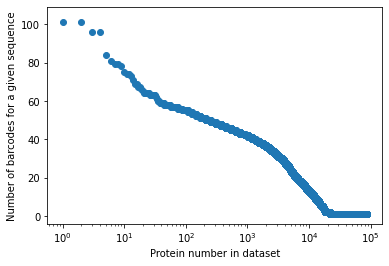

In [8]:
c = Counter(list(zip(binary_data.index)))
duplicated_values = pd.DataFrame(index=range(len(c.values())),data=c.values())
duplicated_values = duplicated_values.sort_values(by=[0],ascending=False)
plt.scatter(range(len(duplicated_values)),duplicated_values[0])
plt.xscale('log')
plt.ylabel('Number of barcodes for a given sequence')
plt.xlabel('Protein number in dataset')

In [9]:
print(f'There are {binary_data.duplicated().sum()} duplicated sequences out of {len(binary_data)} total sequences.') 
print(f'There are {len(duplicated_values)} unique sequences in the dataset')
binary_data #there's going to be a lot more in A than B because A includes ones from the second pool

There are 359878 duplicated sequences out of 400594 total sequences.
There are 86770 unique sequences in the dataset


,low_A,high_A,low_B,high_B
sequence,,,,
NITNLCPFGEVFNATRFASVYAWNRKRISNCVADYSVLYNSASFSTFKCYGVSPTKLNDLCFTNVYADSFVIRGDEVRQIAPGQTGKIADYNYKLPDDFTGCVIAWNSNNLDSKVGGNYNYRYRLFRKSNLKPFERDISTEIYQAGSKPCNGVEGFNCYFPLQSYGFQPTNGVGYPPYRVVVLSFELLHAPATVCGPKKST,0.0,4927.0,NaN,NaN
NITNLCPFDEVFNATRFASVYAWNRKRISNCVADYSVLYNSASFSTFKCYGVSPTKLNDLCFTNVYADSFVIRGDEVRQIAPGQTGKIADYNYKLPDDFTGCVIAWNSNNLDSKVGGNYNYRYRLFRKSNLKPFERDISTEIYQAGSKPCNGVEGFNCYFPLQSYGFQPTNGVGYPPYRVVVLSFELLHAPATVCGPKKST,0.0,2834.0,NaN,NaN
NITNLCPFGEVFNATRFASVYAWNRKRISNCVADYSVLYNSASFSTFKCYGVSPTKLNDLCFTNVYADSDVIRGDEVRQIAPGQTGKIADYNYKLPDDFTGCVIAWNSNNLDSKVGGNYNYRYRLFRKSNLKPFERDISTEIYQAGSKPCNGVEGFNCYFPLQSYGFQPTRGVGYQPYRVVVLSFELLHAPATVCGPKKST,0.0,3116.0,NaN,NaN
NITNLCPFGEVFNATRFASVYAWNRKRISNCVADYSVLYNSASFSTFKCYGVSPTKLNDLCFTNVYADSFVIRGDEVRQIAPGQTFKIADYNYKLPDDFTGCVIAWNSNNLDSKVGGNYNYRYRLFRKSNLKPFERDISTEIYQAGSKPCNGVEGFNCYFPLQSYGFQPTNGVGYQPYRVVVLSFELLHAPLTVCGPKKST,5.0,2320.0,NaN,NaN
NITNLCPFGEVFNATRFASVYAWNRKRISNCVADYSVLYNSASFSTFKCYGVSPTKLNDLCFTNVYADSFVIRGDEVRQIAPGQTGKIADYNYKLPDDFTGCVIAWNSNNLDSKVGGNYNYRYRLFRKSNLKPFERDISTEIYQAGSKPCNGVEGFNCYFPLQSYGFQPTNSVGYQPYRVVVLSFELLHAPATVCGPKKST,0.0,3196.0,NaN,NaN
...,...,...,...,...
NITNLCPFGEVFNATRFASVYAWNRKRISNCVADYSVLYNSASFSTFKCYGVSPTKLNDLCFTNVYADSFVIRGDEVRQIAPGQTGKIADYNYKLPDDFTGCVIAWNSNNLDSKVGGNYTYLYRLFRKSNLKPFERDISTEIYQAGSTPCNGVEGFNCYFPLQSYGFQPTNGVGYQPYRVVVLSFELLHAPATVCGPKKST,0.0,97.0,NaN,NaN
NITNLCPFGEVFNATRFASVYAWNRKRISNCVADYSVLYNSASFSTFKCYGVSPTKLNDLCFTNVYADSFVIRGDEVRQIAPGQGGKIADYNYKLPDDFTGCVIAWNSNNLDSKVGGNYNYLYRLFRKSNLKPFERDISTEIYQAGSTPCNGVEGFNCYFPLQSYGFQPTNGVGYQPYRVVVLSFELLHAPATVCGPKKST,0.0,0.0,NaN,NaN
NITNLCPFGEVFNATRFASVYAWNRKRISNCVADYSVLYNSSSFSTFKCYGVSPTKLNDLCFTNVYADSFVIRGIEVRQIAPGQTGKIADYNYKLPDDFTGCVIAWNSNNLDSKVGGNYNYLYRLFRKSNLKPFERDISTEIYQAGSTPCNGVEGFNCYFPLQSYGFQPTNGVGYQPYRVVVLSFELLHAPATVCGPKKST,0.0,106.0,NaN,NaN


### get ratios from each replicate

In [10]:
#preprocess NGS read counts - get ratio of positive to negative 
replicates = ['A','B']
negative_column = 'low_'
positive_column = 'high_'

for r in replicates:
    #normalize read counts for each pool
    binary_data[positive_column+r] = binary_data[positive_column+r]/binary_data[positive_column+r].sum(axis=0)
    binary_data[negative_column+r] = binary_data[negative_column+r]/binary_data[negative_column+r].sum(axis=0)
    binary_data['ratio_' + r] = np.where(binary_data[negative_column+r] == 0, binary_data[positive_column+r] / (binary_data[binary_data[negative_column+r] != 0][negative_column+r].min(axis=0)), binary_data[positive_column+r] / binary_data[negative_column+r])

#if both low and high are zero remove the ratios from analysis
binary_data.loc[(binary_data['low_A'] == 0) & (binary_data['high_A'] == 0),'ratio_A'] = np.nan
binary_data.loc[(binary_data['low_B'] == 0) & (binary_data['high_B'] == 0),'ratio_B'] = np.nan
binary_data = binary_data.loc[~(pd.isnull(binary_data['ratio_A']) & pd.isnull(binary_data['ratio_B']))]

#drop rows where both ratios are nan
binary_data = binary_data.loc[pd.isnull(binary_data[['ratio_A','ratio_B']]).sum(axis=1) < 2]

In [11]:
binary_data

,low_A,high_A,low_B,high_B,ratio_A,ratio_B
sequence,,,,,,
NITNLCPFGEVFNATRFASVYAWNRKRISNCVADYSVLYNSASFSTFKCYGVSPTKLNDLCFTNVYADSFVIRGDEVRQIAPGQTGKIADYNYKLPDDFTGCVIAWNSNNLDSKVGGNYNYRYRLFRKSNLKPFERDISTEIYQAGSKPCNGVEGFNCYFPLQSYGFQPTNGVGYPPYRVVVLSFELLHAPATVCGPKKST,0.000000,1.872255e-04,NaN,NaN,251.519071,NaN
NITNLCPFDEVFNATRFASVYAWNRKRISNCVADYSVLYNSASFSTFKCYGVSPTKLNDLCFTNVYADSFVIRGDEVRQIAPGQTGKIADYNYKLPDDFTGCVIAWNSNNLDSKVGGNYNYRYRLFRKSNLKPFERDISTEIYQAGSKPCNGVEGFNCYFPLQSYGFQPTNGVGYPPYRVVVLSFELLHAPATVCGPKKST,0.000000,1.076917e-04,NaN,NaN,144.673238,NaN
NITNLCPFGEVFNATRFASVYAWNRKRISNCVADYSVLYNSASFSTFKCYGVSPTKLNDLCFTNVYADSDVIRGDEVRQIAPGQTGKIADYNYKLPDDFTGCVIAWNSNNLDSKVGGNYNYRYRLFRKSNLKPFERDISTEIYQAGSKPCNGVEGFNCYFPLQSYGFQPTRGVGYQPYRVVVLSFELLHAPATVCGPKKST,0.000000,1.184077e-04,NaN,NaN,159.069094,NaN
NITNLCPFGEVFNATRFASVYAWNRKRISNCVADYSVLYNSASFSTFKCYGVSPTKLNDLCFTNVYADSFVIRGDEVRQIAPGQTFKIADYNYKLPDDFTGCVIAWNSNNLDSKVGGNYNYRYRLFRKSNLKPFERDISTEIYQAGSKPCNGVEGFNCYFPLQSYGFQPTNGVGYQPYRVVVLSFELLHAPLTVCGPKKST,0.000004,8.815975e-05,NaN,NaN,23.686797,NaN
NITNLCPFGEVFNATRFASVYAWNRKRISNCVADYSVLYNSASFSTFKCYGVSPTKLNDLCFTNVYADSFVIRGDEVRQIAPGQTGKIADYNYKLPDDFTGCVIAWNSNNLDSKVGGNYNYRYRLFRKSNLKPFERDISTEIYQAGSKPCNGVEGFNCYFPLQSYGFQPTNSVGYQPYRVVVLSFELLHAPATVCGPKKST,0.000000,1.214477e-04,NaN,NaN,163.153024,NaN
...,...,...,...,...,...,...
NITNLCPFGEVFNATRFASVYAWNRKRISNCVADYSVLYNSASFSTFKCYGVSPTKLNWLCFTNVYADSFVIRGDEVRQIAPGQTGKIADYNYKLRDDFTGCVIAWNSNNLDSKVGGNYNYLYRLFRKSNLKPFERDISTEIYQAGSTPCNGVEGFNCYFPLQSYGFQPTNGVGYQPYRVVVLSFELLHAPATVCGPKKST,0.000000,2.887992e-06,NaN,NaN,3.879734,NaN
NITNLCPFGEVFNATRFASVYAWNRKRISNCVADYSVLYNSASFSTFKCYGVSPTKLNDLCFTNVYADSFVIRGDEVRQIAPGQTGKIADYNYKLPDDFTGCVIAWNSNNLDSKVGGNYNYLYRLFRKSNLKPFERDISTEIYQAGSTPCNGVEGFNCYFPLQSYGFQPTNGVGYQPYRVVALSFELLHAPATVCGPKKST,0.000000,6.459982e-07,NaN,NaN,0.867835,NaN
NITNLCPFGEVFNATRFASVYAWNRKRISNCVADYSVLYNSASFSTFKCYGVSPTKLNDLCFTNVYADSFVIRGDEVRQIAPGQTGKIADYNYKLPDDFTGCVIAWNSNNLDSKVGGNYTYLYRLFRKSNLKPFERDISTEIYQAGSTPCNGVEGFNCYFPLQSYGFQPTNGVGYQPYRVVVLSFELLHAPATVCGPKKST,0.000000,3.685990e-06,NaN,NaN,4.951766,NaN


### group sequences by barcode

In [12]:
#group barcodes together for stat calculations
df1 = pd.DataFrame(index=binary_data.index.unique(),columns=binary_data.columns)
df1['ratios'] = binary_data.groupby('sequence')['ratio_A'].apply(lambda x: list(x)) + binary_data.groupby('sequence')['ratio_B'].apply(lambda x: list(x))
df1 = df1.drop(columns=df1.columns[:-1])

In [13]:
#group barcodes together for stat calculations more generally
df1 = pd.DataFrame(index=binary_data.index.unique(),columns=binary_data.columns)
binary_data['ratios'] = binary_data[['ratio_A','ratio_B']].values.tolist()
df1['ratios'] = binary_data.groupby('sequence')['ratios'].apply(lambda x: list([item for sublist in x for item in sublist]))
df1 = df1.drop(columns=df1.columns[:-1])

### get statistics by sequence

In [14]:
#calculate stats
df1['ratios'] = df1['ratios'].apply(lambda x: [i for i in x if not np.isnan(i)])
df1['mean'] = df1['ratios'].apply(lambda x: np.nanmean(x))
df1['count'] = df1['ratios'].apply(lambda x: len(x))
df1['std'] = df1['ratios'].apply(np.std)
df1['min'] = df1['ratios'].apply(min)
df1['max'] = df1['ratios'].apply(max)

In [16]:
df1

,ratios,mean,count,std,min,max
sequence,,,,,,
NITNLCPFGEVFNATRFASVYAWNRKRISNCVADYSVLYNSASFSTFKCYGVSPTKLNDLCFTNVYADSFVIRGDEVRQIAPGQTGKIADYNYKLPDDFTGCVIAWNSNNLDSKVGGNYNYRYRLFRKSNLKPFERDISTEIYQAGSKPCNGVEGFNCYFPLQSYGFQPTNGVGYPPYRVVVLSFELLHAPATVCGPKKST,"[251.5190705499922, 65.90442867465799, 55.8477...",29.582242,35,42.984073,0.051049,251.519071
NITNLCPFDEVFNATRFASVYAWNRKRISNCVADYSVLYNSASFSTFKCYGVSPTKLNDLCFTNVYADSFVIRGDEVRQIAPGQTGKIADYNYKLPDDFTGCVIAWNSNNLDSKVGGNYNYRYRLFRKSNLKPFERDISTEIYQAGSKPCNGVEGFNCYFPLQSYGFQPTNGVGYPPYRVVVLSFELLHAPATVCGPKKST,[144.67323846938865],144.673238,1,0.000000,144.673238,144.673238
NITNLCPFGEVFNATRFASVYAWNRKRISNCVADYSVLYNSASFSTFKCYGVSPTKLNDLCFTNVYADSDVIRGDEVRQIAPGQTGKIADYNYKLPDDFTGCVIAWNSNNLDSKVGGNYNYRYRLFRKSNLKPFERDISTEIYQAGSKPCNGVEGFNCYFPLQSYGFQPTRGVGYQPYRVVVLSFELLHAPATVCGPKKST,[159.06909353232712],159.069094,1,0.000000,159.069094,159.069094
NITNLCPFGEVFNATRFASVYAWNRKRISNCVADYSVLYNSASFSTFKCYGVSPTKLNDLCFTNVYADSFVIRGDEVRQIAPGQTFKIADYNYKLPDDFTGCVIAWNSNNLDSKVGGNYNYRYRLFRKSNLKPFERDISTEIYQAGSKPCNGVEGFNCYFPLQSYGFQPTNGVGYQPYRVVVLSFELLHAPLTVCGPKKST,[23.686796982990945],23.686797,1,0.000000,23.686797,23.686797
NITNLCPFGEVFNATRFASVYAWNRKRISNCVADYSVLYNSASFSTFKCYGVSPTKLNDLCFTNVYADSFVIRGDEVRQIAPGQTGKIADYNYKLPDDFTGCVIAWNSNNLDSKVGGNYNYRYRLFRKSNLKPFERDISTEIYQAGSKPCNGVEGFNCYFPLQSYGFQPTNSVGYQPYRVVVLSFELLHAPATVCGPKKST,"[163.1530240466359, 38.235799440215985, 18.888...",13.754095,42,25.799569,0.153147,163.153024
...,...,...,...,...,...,...
NITNLCPFGEVFNATRFASVYAWNRKRISNCVADYSVLYNSASFSTFKCYGVSPTKLNDLCFTNVYADSFVIRGDEVRQIAPGQTGKIADYNYKLPDDFTGCVVAWNSNNLDSKVGGNYNYLYRLFRKSNLKPFERDISTEIYQAGSTPCNGVEGFNCYFPLQSYGFQPTNGVGYQPYRVVVLSFGLLHAPATVCGPKKST,[1.225179154292635],1.225179,1,0.000000,1.225179,1.225179
NITNLCPFGEVFNATRFASVYAWTRKRISNCVAYYSVLYNSASFSTFKCYGVSPTKLNDLCFTNVYADSFVIRGDEVRQIAPGQTGKIADYNYKLPDDFTGCVIAWNSNNLDSKVGGNYNYLYRLFRKSNLKPFERDISTEIYQAGSTPCNGVEGFNCYFPLQSYGFQPTNGVGYQPYRVVVLSFELLHAPATVCGPKKST,[1.4804248114369338],1.480425,1,0.000000,1.480425,1.480425
NITNLCPFGEVFNATRFASVYAWNRKRISNCVADYSVLYNSAGFSTFKCYGVSPTKLIDLCFTNVYADSFVIRGDEVRQIAPGQTGKIADYNYKLPDDFTGCVIAWNSNNLDSKVGGNYNYLYRLFRKSNLKPFERDISTEIYQAGSTPCNGVEGFNCYFPLQSYGFQPTNGVGYQPYRVVVLSFELLHAPATVCGPKKST,[1.8377687314389526],1.837769,1,0.000000,1.837769,1.837769


In [17]:
df1.to_csv('binary_bloom2022.csv')

### plot distribution of mean ratios for each sequence in the dataset

Text(0, 0.5, 'positive:negative average ratio')

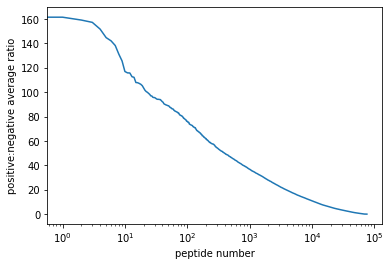

In [19]:
plt.plot(range(len(df1)),df1['mean'].sort_values(ascending=False))
plt.xscale('log')
plt.xlabel('peptide number')
plt.ylabel('positive:negative average ratio')

In [20]:
df1.sort_values(by='count',ascending=False)['ratios']

sequence
 NITNLCPFGEVFNATRFASVYAWNRKRISNCVADYSVLYNSASFSTFKCYGVSPTKLNDLCFTNVYADSFVIRGDEVRQIAPGQTGKIADYNYKLPDDFTGCVIAWNSNNLDSKVGGNYNYLYRLFRKSNLKPFERDISTEIYQAGSTPCNGVEGFNCYFPLQSYGFQPTLGVGYQPYRVVVLSFELLHAPATVCGPKKST    [2.0930143885832515, 7.963084540958669, 0.8678...
 NITNLCPFGEVFNATRFASVYAWNRKRISNCVADYSVLYNSASFSTFKCYGVSPTKLNDLCFTNVYADSFVIRGDEVRQIAPGQTGKIADYNYKLPDDFTGCVIAWNSNNLDSKVGGNYNYLYRLFRKSNLKPFERDISTEIYQAGSTPCNGVKGFNCYFPLQSYGFQPTLGVGYQPYRVVVLSFELLHAPATVCGPKKST    [0.5615404457174576, 0.38376311040764666, 2.29...
 NITNLCPFGEVFNATRFASVYAWNRKRISNCVADYSVLYNSASFSTFKCYGVSPTKLNDLCFTNVYADSFVIRGDEVRQIAPGQTGKIADYNYKLPDDFTGCVIAWNSNNLDSKVGGNYNYLYRLFRKSNLKPFERDISTEIYQAGSTPCNGVKGFNCYFPLQSYGFQPTRGVGYQPYRVVVLSFELLHAPATVCGPKKST    [1.0720317600060556, 0.6715854432133818, 3.471...
 NITNLCPFGEVFNATRFASVYAWNRKRISNCVADYSVLYNSASFSTFKCYGVSPTKLNDLCFTNVYADSFVIRGDEVRQIAPGQTGKIADYNYKLPDDFTGCVIAWNSNNLDSKVGGNYNYLYRLFRKSNLKPFERDISTEIYQAGSTPCNGVKGFNCYFPLQSYGFQPTYGVGYQPYRVVVLSFELLHAPATVCGPKKST    [0.00217230346505

### plot distributions of statistics for dataset

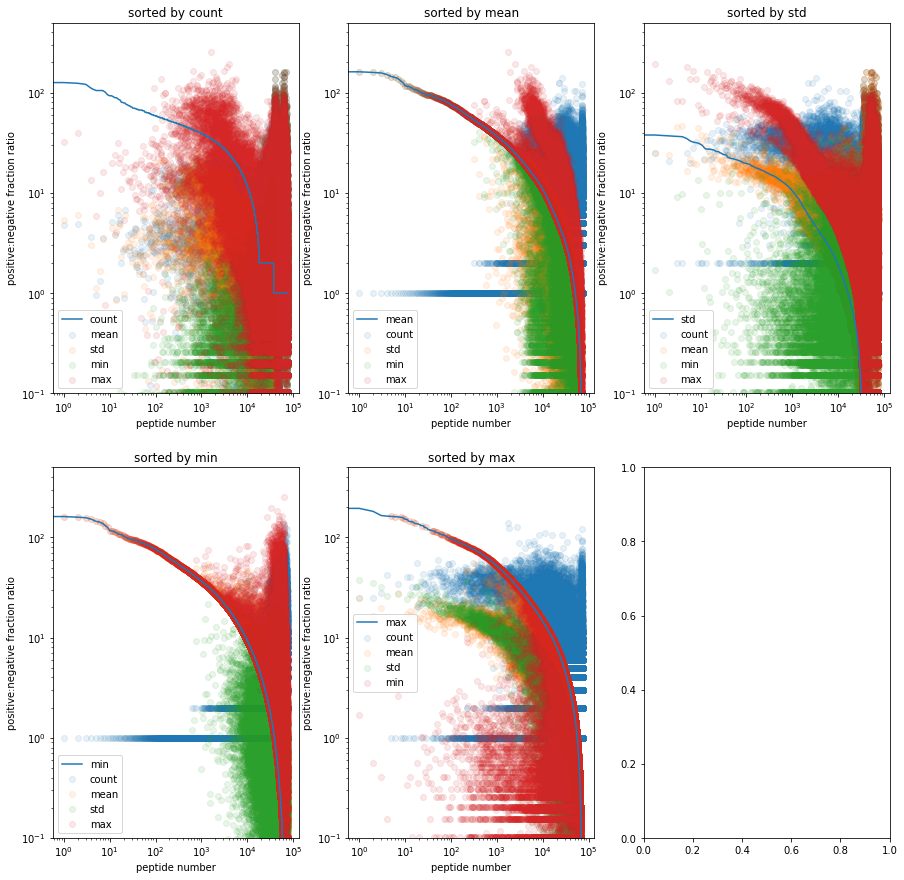

In [21]:
#plot distribution of ratios. where should we draw the cutoff for positive clones?
fig,axes = plt.subplots(nrows=2,ncols=3,figsize=(15,15))
stats = ['count','mean','std','min','max']
for ax,sort_stat in zip(np.ravel(axes),stats):
    for s in stats:
        if s == sort_stat:
            ax.plot(range(len(df1)),df1[s].sort_values(ascending=False),label=s)
        else:
            ax.scatter(range(len(df1)),df1.sort_values(axis=0,by=sort_stat,ascending=False)[s],label=s,alpha=0.1)

    
    ax.set_xscale('log')
    ax.set_yscale('log')
    ax.set_xlabel('peptide number')
    ax.set_ylabel('positive:negative fraction ratio')
    ax.legend()
    ax.set_ylim([1e-1,5e2])
    ax.set_title('sorted by ' + sort_stat)

### take a look at some of the top clones in the dataset. how many times were they observed?

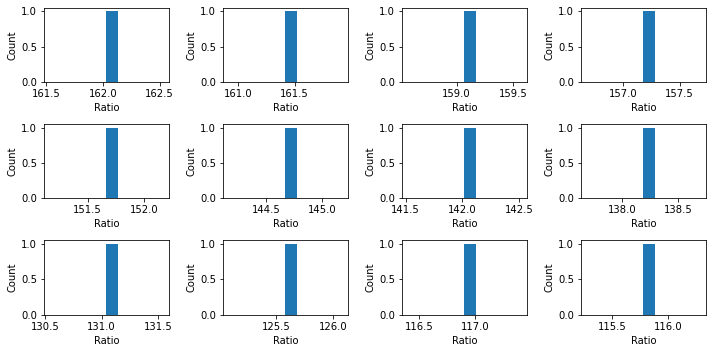

In [22]:
#what's the distribution of ratios across a given sequence look like? plot for some of the most highly observed sequences
fig,axes = plt.subplots(nrows=3,ncols=4,figsize=(10,5))
for i,ax in enumerate(np.ravel(axes)):
    plot_data = df1.sort_values(by='mean',ascending=False)['ratios'][i]
    
    ax.hist(plot_data)
    ax.set_xlabel('Ratio')
    ax.set_ylabel('Count')
plt.tight_layout()

### so, most of the highest ratio clones only have a single barcode replicate. what if we limit it to clones with more than 1 replicate?

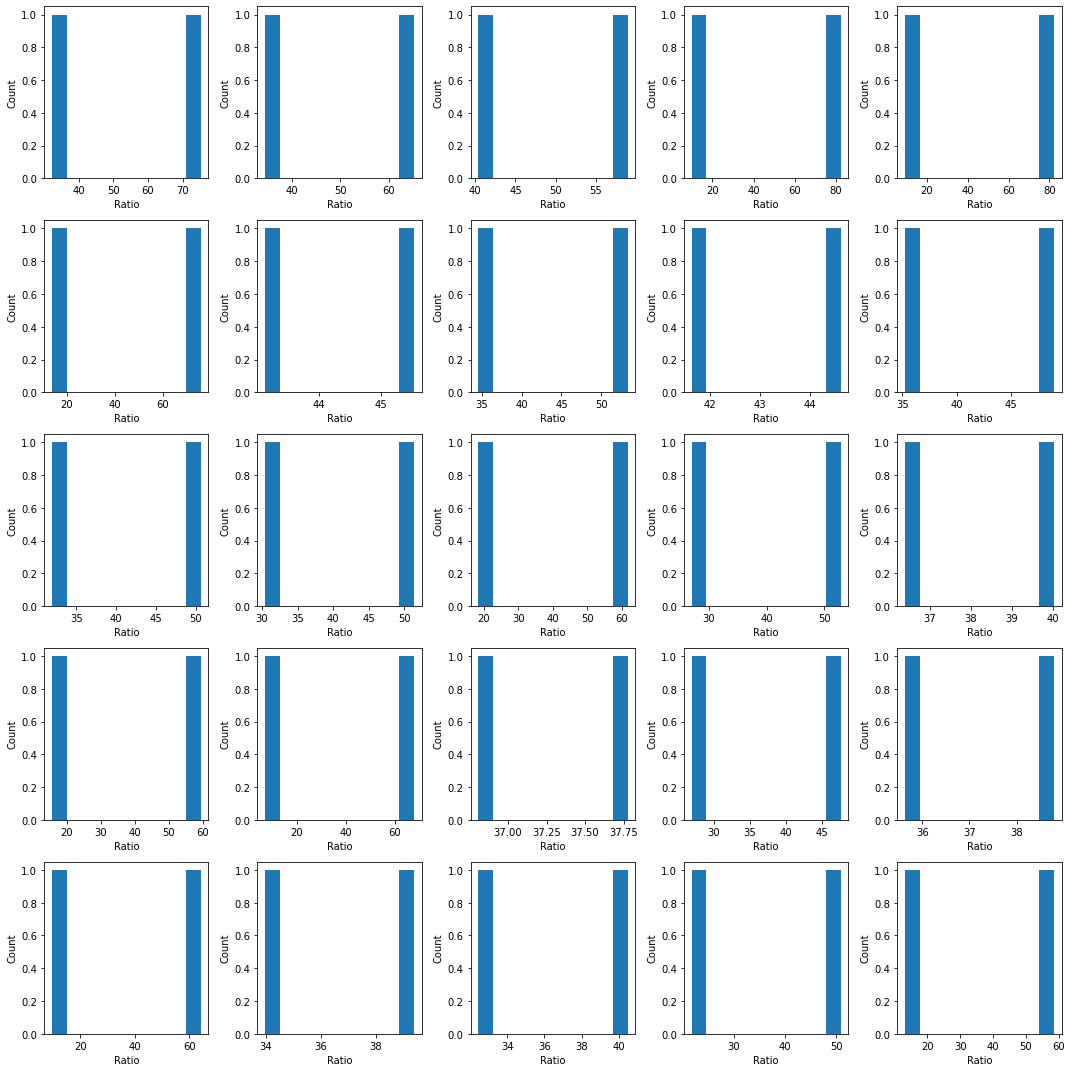

In [23]:
#what's the distribution of ratios across a given sequence look like IF we remove single counts? plot for some of the most highly observed sequences
fig,axes = plt.subplots(nrows=5,ncols=5,figsize=(15,15))
for i,ax in enumerate(np.ravel(axes)):
    plot_data = df1.loc[df1['count'] > 1].sort_values(by='mean',ascending=False)['ratios'][i]
    
    ax.hist(plot_data)
    ax.set_xlabel('Ratio')
    ax.set_ylabel('Count')
plt.tight_layout()

### apply filters to the dataset based on replicate cutoffs and percentile cutoffs

Text(0.5, 1.0, 'size of positive dataset')

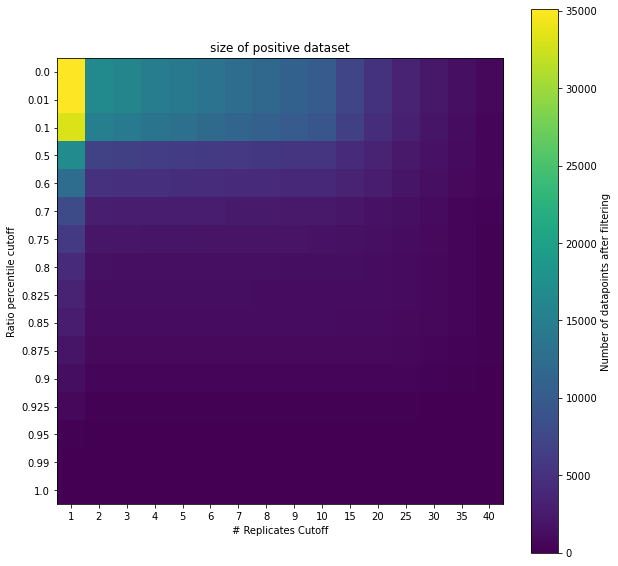

In [24]:
#set some stringencies for cutoffs and see how large the positive dataset is
cutoff_percentiles = [0,0.01,0.1,0.5,0.6,0.7,0.75,0.8,0.825,0.85,0.875,0.9,0.925,0.95,0.99,1]
number_of_replicates = [1,2,3,4,5,6,7,8,9,10,15,20,25,30,35,40]
datasize_df = pd.DataFrame(index=cutoff_percentiles,columns=number_of_replicates)
for i,n in enumerate(number_of_replicates):
    for j,c in enumerate(cutoff_percentiles):
        data_slice = df1[['mean','count']]
        data_slice = data_slice.loc[(data_slice['mean'] > data_slice['mean'].quantile(c)) & (data_slice['count'] > n)]
        l = len(data_slice)
        datasize_df.loc[c,n] = l
        # print(f"Number of replicates is: {n}. Percentile cutoff is: {c}. Length of dataset is: {l}")


#plot results
fig,ax = plt.subplots(figsize=(10,10))
pos = ax.imshow(datasize_df.values.astype('int'))
xticks = range(len(datasize_df.columns))
yticks = range(len(datasize_df.index))
ax.set_xticks(xticks)
ax.set_yticks(yticks)
ax.set_xticklabels(datasize_df.columns)
ax.set_yticklabels(datasize_df.index)
ax.set_xlabel('# Replicates Cutoff')
ax.set_ylabel('Ratio percentile cutoff')
cbar = fig.colorbar(pos, ax=ax)
cbar.set_label('Number of datapoints after filtering')
# for (i, j), z in np.ndenumerate(datasize_df):
#     ax.text(j, i, str(z), ha='center', va='center',color='white')
plt.title('size of positive dataset')

In [25]:
data_slice['mean']

Series([], Name: mean, dtype: float64)

Text(0.5, 1.0, 'size of negative dataset')

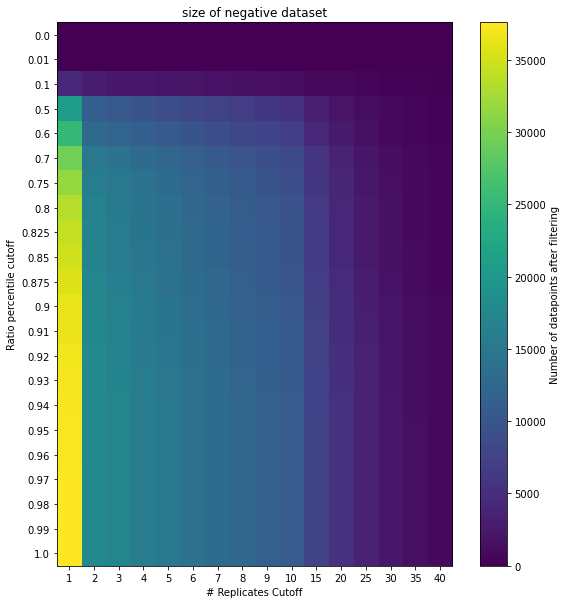

In [ ]:
#set some stringencies for cutoffs and see how large the negative dataset is
cutoff_percentiles = [0,0.01,0.1,0.5,0.6,0.7,0.75,0.8,0.825,0.85,0.875,0.9,0.91,0.92,0.93,0.94,0.95,0.96,0.97,0.98,0.99,1]
number_of_replicates = [1,2,3,4,5,6,7,8,9,10,15,20,25,30,35,40]
datasize_df = pd.DataFrame(index=cutoff_percentiles,columns=number_of_replicates)

for i,n in enumerate(number_of_replicates):
    for j,c in enumerate(cutoff_percentiles):
        data_slice = df1[['mean','count']]
        data_slice = data_slice.loc[(data_slice['mean'] < data_slice['mean'].quantile(c)) & (data_slice['count'] > n)]
        l = len(data_slice)
        datasize_df.loc[c,n] = l
        # print(f"Number of replicates is: {n}. Percentile cutoff is: {c}. Length of dataset is: {l}")

#plot results
fig,ax = plt.subplots(figsize=(10,10))
pos = ax.imshow(datasize_df.values.astype('int'))
xticks = range(len(datasize_df.columns))
yticks = range(len(datasize_df.index))
ax.set_xticks(xticks)
ax.set_yticks(yticks)
ax.set_xticklabels(datasize_df.columns)
ax.set_yticklabels(datasize_df.index)
ax.set_xlabel('# Replicates Cutoff')
ax.set_ylabel('Ratio percentile cutoff')
cbar = fig.colorbar(pos, ax=ax)
cbar.set_label('Number of datapoints after filtering')
# for (i, j), z in np.ndenumerate(datasize_df):
#     ax.text(j, i, str(z), ha='center', va='center',color='white')
plt.title('size of negative dataset')

,mean
sequence,
NITNLCPFGEVFNATRFASVYAWNRKRISNCVADYSVLYNSASFSTFKCYGVSPTKLNDLCFTNVYADSFVIRGDEVRQIAPGQTGKIADYNYKLPDDFTGCVIAWNSNNLDSKVGGNYNYRYRLFRKSNLKPFERDISTEIYQAGSKPCNGVEGFNCYFPLQSYGFQPTNGVGYPPYRVVVLSFELLHAPATVCGPKKST,29.582242
NITNLCPFGEVFNATRFASVYAWNRKRISNCVADYSVLYNSASFSTFKCYGVSPTKLNDLCFTNVYADSFVIRGDEVRQIAPGQTGKIADYNYKLPDDFTGCVIAWNSNNLDSKVGGNYNYRYRLFRKSNLKPFERDISTEIYQAGSKPCNGVEGFNCYFPLQSYGFQPTNSVGYQPYRVVVLSFELLHAPATVCGPKKST,13.754095
NITNLCPFGEVFNATRFASVYAWNRKRISNCVADYSVLYNSASFSTFKCYGVSPTKLNDLCFTNVYADSFVIRGDEVRQIAPGQTGKIADYNYKLPDDFTGCVIAWNSNNLDSKVGGNYNYRYRLFRKSNLKPFERDISTEIYQAGSKPCNGVEGFNCYFPLQSYGFQPTNIVGYQPYRVVVLSFELLHAPATVCGPKKST,17.687815
NITNLCPFGEVFNATRFASVYAWNRKRISNCVADYSVLYNSASFSTFKCYGVSPTKLNDLCFTNVYADSFVIRGDEVRQIAPGQTGKIADYNYKLPDDFTGCVIAWNSNNLDSKVGGNYNYRYRLFRKSNLKPFERDISTEIYQAGSKPCNGVEGFNCYFPLQSYGFQPTNGVGYQFYRVVVLSFELLHAPATVCGPKKST,23.931533
NITNLCPFGEVFNATRFASVYAWNRKRISNCVADYSVLYNSASFSTFKCYGVSPTKLNDLCFTNVYADSFVIRGDEVRQIAPGQTGKIADYNYKLPDDFTGCVIAWNSNNLDSKVGGNYNYRYRLFRKSNLKPFERDISTEIYQAGSKPCNGVEGFNCSFPLQSYGFQPTNGVGYQPYRVVVLSFELLHAPATVCGPKKST,21.130605
...,...
NITNLCPFGEVFNATRFASVYAWNRKRISNCVADYSVLYNSASFSTFKCYGVSPTKLNDLCFTNVYADSFVIRGDEVRQIAPGQTGKIADYNYKLPDDFTGCVIAWNSNNLDSKVGGNYNYLYRLFRKSNLKPFERDISTEIYQAGSTPCNGVEGFNCYFPLQSYGFQPTNGVGYQHYRVVVLSFELLHAPATVCGPKKST,4.526356
NITNLCPFGEVFNATRFASVYAWNRKRISNCVADYSVLYNSASFSTFKCYGVSPTKLNDLCFTNVYADSFVIRGDEVRQIAPGQTGKIADYNYKLPDDFTGCVIAWNSNNLDSKVGGNYNYLYRLFRKSNLKPFERDISTEIYQAGSTPCNGVEGFNCYFPLQSYGFQPTNGVGLQPYRVVVLSFELLHAPATVCGPKKST,4.160504
NITNLCPFGEVFNATRFASVYAWNRKRISNCVADYSVLYNSASFSTFKCYGVSPTKLNDLCFTNVYADSFVIRGDEVRQIAPGQTGKIADYNYKLPDDFTGCVIAWNSNNLDSKVGGNYNYLYRLFRKSNLKPFERRISTEIYQAGSTPCNGVEGFNCYFPLQSYGFQPTNGVGYQPYRVVVLSFELLHAPATVCGPKKST,3.143168


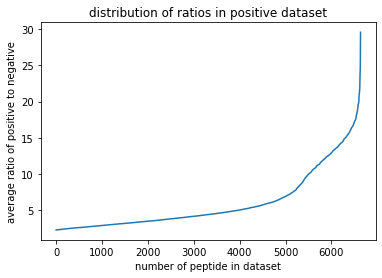

In [ ]:
#look at the positive sequences after choosing a filter
c = 0.5 #quantile cut-off
n = 3 #number of replicates cut-off
data_slice = df1.loc[(df1['mean'] > df1['mean'].quantile(c)) & (df1['count'] > n)]
plt.plot(range(len(data_slice)),data_slice.sort_values('mean')['mean'])
plt.xlabel('number of peptide in dataset')
plt.ylabel('average ratio of positive to negative')
plt.title('distribution of ratios in positive dataset')
data_slice[['mean']]

,mean
sequence,
NITNLCPFGEVFNATRFASVYAWNRKRISNCVADYSVLYNSASFSTFKCYGVSPTKLNDLCFTNVYADSFVIRGDEVRQIAPGQTGKIADYNYKLPDDFTGCVIAWNSVNLDSKVGGNYNYRYRLFRKSNLKPFERDISTEIYQAGSKPCNGVEGFNCYFPLQSYGFQPTNGVGYQPYRVVVLSFELLHAPATVCGPKKST,0.001967
NITNLCPFGEVFNATRFASVYAWNRKRISNCVADYSVLYNSASFSTFKCYGVSPTKLNDLCFTNVYADSFVIRGDEVRQIAPGQTGKIADYNYKLPDDFTGCVIAWNSNNLDSKVGGNYNYRYRLFRKSNLKPFERDISTEIYQAGSKPCNGVEGFNCYFPLYSYGFQPTNGVGYQPYRVVVLSFELLHAPATVCGPKKST,0.002049
NITNLCPFGEVFNATRFASVYAWNRKRISNCVADYSVLYNSASFSTFKCYGVSPTKLNDLCFTNVYADSFVIRGDEVRQIAPGQTGKIADYNYKLPDDFTGCVIAWNSNNLDSKVGGNYNYRYRLFRKSNLKPFERDISTEIYQAGSKPCNGVEGFNCYFPLCSYGFQPTNGVGYQPYRVVVLSFELLHAPATVCGPKKST,0.006717
NITNLCPFGEVFNATRFASVYAWNRKRISNCVADYSVLYNSASFSTFKCYGVSPTKLNDLCFTNVYADSFVIRGDEVRQIAPGQTGKIADYNYKLPDDFTGCVIAWNSNNLDSKVGGNYNYRYRLFRKSNLKPFERDISTEIYQAGSKPCNGVEGFNCYFPLLSYGFQPTNGVGYQPYRVVVLSFELLHAPATVCGPKKST,0.002166
NITNLCPFGEVFNATRFASVYAWNRKRISNCVADYSVLYNSASFSTFKCYGVSPTKLNDLCFTNVYADSFVIRGDEVRQIAPGQTGKIADYNYKLPDDFTGCVIAWNSNNLDSKVGGNYNYRYRLFRKSNLKPFERDISTEIYQAGNKPCNGVEGFNCYFPLQSYGFQPTNGVGYQPYRVVVLSFELLHAPATVCGPKKST,0.002099
...,...
NITNLCPFGEVFNATRFASVYAWNRKRISNCVADYSVLYNSASFSTFKCYGVSPTKLNDLCFTNVYADSFVIRGDEVRQIAPGQTGKIADYNYKLPDDFTGCVIAWNSNNLDSKVGGNYNYLYRLFRKSNLKPFERDISTEIYQAGSTPCNGVEGFNCYFPLYSYGFQPTNGVGYQPYRVVVLSFELLHAPATVCGPKKST,0.017251
NITNLCPFGEVFNATRFASVYAWNRKRISNCVADYSVLYNSASFSTFKCYGVSPTKLNDLCFTNVYADSFVIRGDEVRQIAPGQTGKIADYNYKLPDDFTGCVIAWNSNNLDSKVGGNYNYLFRLFRKSNLKPFERDISTEIYQAGSTPCNGVEGFNCYFPLQSYGFQPTNGVGYQPYRVVVLSFELLHAPATVCGPKKST,0.000000
NITNLCPFGEVFNATRFASVYAWNRKRISNCVADYSVLYNSASFSTFKCYGVSPTKLNDLCFTNVYADSFVIRGDEVRQIAPGQTGKIADYNYKLPDDFTGCVIAWNSNNLDSKVGGNYNYQYRLFRKSNLKPFERDISTEIYQAGSTPCNGVEGFNCYFPLQSYGFQPTNGVGYQPYRVVVLSFELLHAPATVCGPKKST,0.043756


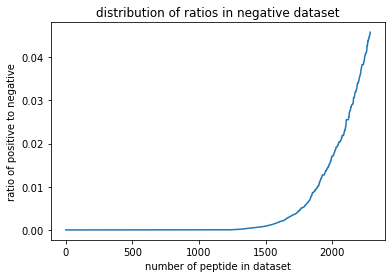

In [ ]:
#look at the negative  sequences after choosing a filter
c = 0.08 #quantile cut-off
n = 3 #number of replicates cut-off
data_slice = df1.loc[(df1['mean'] < df1['mean'].quantile(c)) & (df1['count'] > n)]
plt.plot(range(len(data_slice)),data_slice.sort_values('mean')['mean'])
plt.xlabel('number of peptide in dataset')
plt.ylabel('ratio of positive to negative')
plt.title('distribution of ratios in negative dataset')
data_slice[['mean']]